In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
# ----- Cấu hình -----
latent_dim = 100       # Kích thước không gian tiềm ẩn
batch_size = 64
lr = 0.0002
epochs = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# ----- Dataset -----
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

train_loader = DataLoader(
    datasets.MNIST('.', train=True, download=True, transform=transform),
    batch_size=batch_size, shuffle=True
)

100.0%
100.0%
100.0%
100.0%


In [4]:
# ----- Mạng Generator -----
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 256),
            nn.ReLU(True),
            nn.Linear(256, 28*28),
            nn.Tanh()  # output lung range [-1,1]
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(z.size(0), 1, 28, 28)
        return img

# ----- Mạng Discriminator -----
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 1),
            nn.Sigmoid()  # output xác suất
        )

    def forward(self, img):
        return self.model(img)

In [5]:
# ----- Khởi tạo mô hình và tối ưu hóa -----
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)

criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=lr)
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr)

[Epoch 1/20]  Loss_D: 0.0073, Loss_G: 5.5026


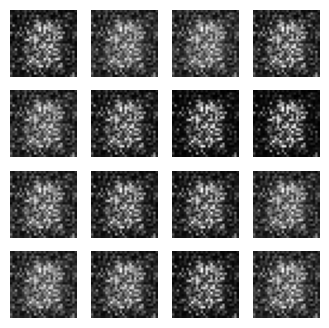

[Epoch 2/20]  Loss_D: 0.0971, Loss_G: 3.0858
[Epoch 3/20]  Loss_D: 0.5160, Loss_G: 1.9408
[Epoch 4/20]  Loss_D: 0.2284, Loss_G: 2.6968
[Epoch 5/20]  Loss_D: 0.1178, Loss_G: 3.5394


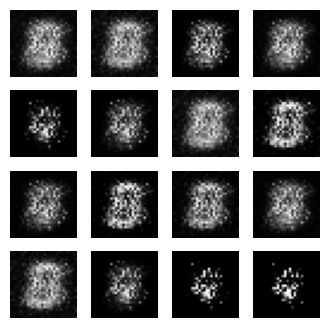

[Epoch 6/20]  Loss_D: 0.0167, Loss_G: 4.6507
[Epoch 7/20]  Loss_D: 0.0846, Loss_G: 4.6924
[Epoch 8/20]  Loss_D: 0.0406, Loss_G: 4.6550
[Epoch 9/20]  Loss_D: 0.1521, Loss_G: 3.2342
[Epoch 10/20]  Loss_D: 0.0186, Loss_G: 4.9309


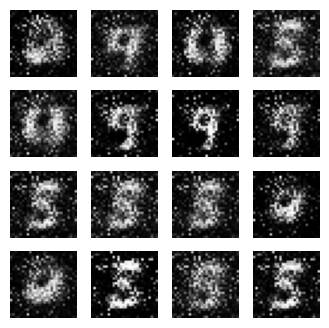

[Epoch 11/20]  Loss_D: 0.1562, Loss_G: 3.0050
[Epoch 12/20]  Loss_D: 0.0733, Loss_G: 4.6338
[Epoch 13/20]  Loss_D: 0.0823, Loss_G: 3.6635
[Epoch 14/20]  Loss_D: 0.1270, Loss_G: 4.5186
[Epoch 15/20]  Loss_D: 0.1466, Loss_G: 4.4123


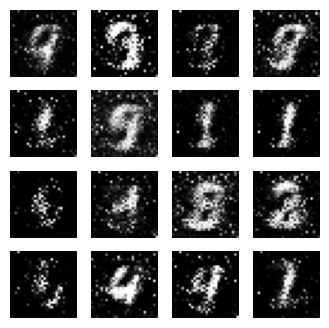

[Epoch 16/20]  Loss_D: 0.1476, Loss_G: 3.8837
[Epoch 17/20]  Loss_D: 0.0715, Loss_G: 5.0462
[Epoch 18/20]  Loss_D: 0.1294, Loss_G: 4.1792
[Epoch 19/20]  Loss_D: 0.1752, Loss_G: 3.1473
[Epoch 20/20]  Loss_D: 0.0674, Loss_G: 4.7649


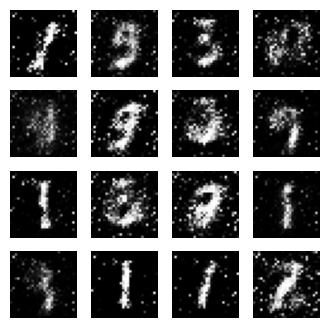

In [6]:
# ----- Training -----
for epoch in range(1, epochs + 1):
    for real_imgs, _ in train_loader:
        real_imgs = real_imgs.to(device)
        batch_size_cur = real_imgs.size(0)

        # Tạo nhãn
        valid = torch.ones(batch_size_cur, 1, device=device)
        fake = torch.zeros(batch_size_cur, 1, device=device)

        # --- 1. Training Discriminator ---
        optimizer_D.zero_grad()
        # Real images
        real_pred = discriminator(real_imgs)
        loss_real = criterion(real_pred, valid)

        # Fake images
        z = torch.randn(batch_size_cur, latent_dim, device=device)
        gen_imgs = generator(z)
        fake_pred = discriminator(gen_imgs.detach())
        loss_fake = criterion(fake_pred, fake)

        loss_D = (loss_real + loss_fake) / 2
        loss_D.backward()
        optimizer_D.step()

        # --- 2. Training Generator ---
        optimizer_G.zero_grad()
        gen_pred = discriminator(gen_imgs)
        loss_G = criterion(gen_pred, valid)  # Generator muốn phân biệt là thật
        loss_G.backward()
        optimizer_G.step()

    print(f"[Epoch {epoch}/{epochs}]  Loss_D: {loss_D.item():.4f}, Loss_G: {loss_G.item():.4f}")

    # Hiển thị ảnh sinh ra mỗi vài epoch
    if epoch % 5 == 0 or epoch == 1:
        with torch.no_grad():
            test_z = torch.randn(16, latent_dim, device=device)
            test_imgs = generator(test_z).cpu()
            fig, axes = plt.subplots(4, 4, figsize=(4, 4))
            for img, ax in zip(test_imgs, axes.flatten()):
                ax.imshow(img.squeeze() * 0.5 + 0.5, cmap='gray')
                ax.axis('off')
            plt.show()
